# Mount

In [1]:
from google.colab import drive
import os, sys
drive.mount('/content/drive/')

Mounted at /content/drive/


# Imports

In [2]:
import pandas as pd
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

# Read data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/processed_data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,DateUTC,DateShort,LoadConsumption,Date,Hour,Year,Week,WeekKey,day_of_week,DailyPrecipitation,...,Elektriciteit_Vast_leveringstarief_incl_btw,Elektriciteit_Vast_leveringstarief_ex_btw,Elektriciteit_Variabel_leveringstarief_incl_btw,Elektriciteit_Variabel_leveringstarief_ex_btw,Elektriciteit_Opslag_duurzame_energie_(ODE)_incl_btw,Elektriciteit_Opslag_duurzame_energie_(ODE)_ex_btw,Elektriciteit_Energiebelasting_incl_btw,Elektriciteit_Energiebelasting_ex_btw,Elektriciteit_Vermindering_energiebelasting_incl_btw,Elektriciteit_Vermindering_energiebelasting_ex_btw
0,2021-01-01 00:00:00,01/01/2021,11313.1375,2021-01-01,1,2021,53,202153,Friday,0.0,...,71.33,58.95,0.0697,0.0576,0.03630,0.0300,0.11408,0.09428,-558.56,-461.62
1,2021-01-01 01:00:00,01/01/2021,10925.1475,2021-01-01,2,2021,53,202153,Friday,0.0,...,71.33,58.95,0.0697,0.0576,0.03630,0.0300,0.11408,0.09428,-558.56,-461.62
2,2021-01-01 02:00:00,01/01/2021,10576.8200,2021-01-01,3,2021,53,202153,Friday,0.0,...,71.33,58.95,0.0697,0.0576,0.03630,0.0300,0.11408,0.09428,-558.56,-461.62
3,2021-01-01 03:00:00,01/01/2021,10371.1225,2021-01-01,4,2021,53,202153,Friday,0.0,...,71.33,58.95,0.0697,0.0576,0.03630,0.0300,0.11408,0.09428,-558.56,-461.62
4,2021-01-01 04:00:00,01/01/2021,10420.2075,2021-01-01,5,2021,53,202153,Friday,0.0,...,71.33,58.95,0.0697,0.0576,0.03630,0.0300,0.11408,0.09428,-558.56,-461.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2022-12-31 19:00:00,31/12/2022,11582.1600,2022-12-31,20,2022,52,202252,Saturday,21.2,...,65.36,59.96,0.5200,0.4770,0.03325,0.0305,0.04010,0.03679,-742.98,-681.63
17516,2022-12-31 20:00:00,31/12/2022,10979.1150,2022-12-31,21,2022,52,202252,Saturday,21.2,...,65.36,59.96,0.5200,0.4770,0.03325,0.0305,0.04010,0.03679,-742.98,-681.63
17517,2022-12-31 21:00:00,31/12/2022,10531.2800,2022-12-31,22,2022,52,202252,Saturday,21.2,...,65.36,59.96,0.5200,0.4770,0.03325,0.0305,0.04010,0.03679,-742.98,-681.63
17518,2022-12-31 22:00:00,31/12/2022,10203.9575,2022-12-31,23,2022,52,202252,Saturday,21.2,...,65.36,59.96,0.5200,0.4770,0.03325,0.0305,0.04010,0.03679,-742.98,-681.63


# Select predictors

In [240]:
possible_predictors = [
    'Hour', 'Year', 'Week', 'WeekKey',
    'DailyPrecipitation',
    'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
    'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
    'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
    'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
    'Month', 'NAO', 'Biomassa (%)', 'Windenergie (%)', 'Zonne-energie (%)',
    'Warmtepompen (%)', 'Overig (%)', 'Statistische overdracht (%)',
    'Aardgas_Vast_leveringstarief_incl_btw', 'Aardgas_Vast_leveringstarief_ex_btw',
    'Aardgas_Variabel_leveringstarief_incl_btw', 'Aardgas_Variabel_leveringstarief_ex_btw',
    'Elektriciteit_Vast_leveringstarief_incl_btw', 'Elektriciteit_Vast_leveringstarief_ex_btw',
    'Elektriciteit_Variabel_leveringstarief_incl_btw', 'Elektriciteit_Variabel_leveringstarief_ex_btw',
]

n_predictors = 5
alpha = 0.05

predictors_dict = {}
for predictor in possible_predictors:
    corr, p_value = pearsonr(df['LoadConsumption'], df[predictor])
    if p_value < alpha:
        predictors_dict[predictor] = corr

sorted_items = sorted(predictors_dict.items(), key=lambda x: abs(x[1]), reverse=True)

predictors = []
for key, value in sorted_items:
    if len(predictors) < n_predictors:
        predictors.append(key)

print(predictors)

['HourlyMaxTemperature', 'DailyMeanTemperature', 'Hour', 'HourlyMinTemperature', 'Year']


In [241]:
cols_to_select = predictors.copy()
cols_to_select.append('DateUTC')
cols_to_select.append('LoadConsumption')
df_subset = df[cols_to_select]
df_subset.set_index('DateUTC', inplace=True)

# Prophet

In [242]:
from prophet import Prophet
import math
from sklearn.metrics import mean_squared_error


def initialize_prophet(regressors, add_seasonality, fourier_weekly, fourier_annual, automatic):
    """
    Initialize prophet. Either with specified seasonalities or default.
    Add regressors if any are entered.
    """
    if add_seasonality:
        if automatic:
            model = Prophet(
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
            )
        else:
            model = Prophet(
                daily_seasonality=False,
                weekly_seasonality=fourier_weekly,
                yearly_seasonality=fourier_annual,
            )

    else:
        model = Prophet()

    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)

    return model

def run_model(df, regressors, add_seasonality, fourier_weekly, fourier_annual, automatic):
    """
    Run model.
    Give predictions.
    Calculate RMSE.
    """

    # intialize model
    model = initialize_prophet(regressors, add_seasonality, fourier_weekly, fourier_annual, automatic)

    # fit model
    model.fit(df)

    # predict with model
    forecast = model.predict(df)
    forecast['yhat_rounded'] = forecast['yhat'].apply(lambda x: math.floor(x))

    # calculate rmse
    rmse = math.sqrt(mean_squared_error(df['y'], forecast['yhat_rounded'][-len(df):]))

    corr, p_value = pearsonr(df['y'], forecast['yhat_rounded'][-len(df):])
    print(f'Correlation: {corr} and p-value: {p_value} on All Data')
    return forecast, model

### fit prophet to entire df and also let it predict for the df

In [243]:
forecast, model = run_model(
    df= df_subset.reset_index().rename(columns={'DateUTC':'ds', 'LoadConsumption':'y'}),
    regressors=predictors,
    add_seasonality=True,
    fourier_weekly=7,
    fourier_annual=12,
    automatic=True
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzf8rjkk1/pw9cgh9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzf8rjkk1/i0aw6jyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68070', 'data', 'file=/tmp/tmpzf8rjkk1/pw9cgh9_.json', 'init=/tmp/tmpzf8rjkk1/i0aw6jyf.json', 'output', 'file=/tmp/tmpzf8rjkk1/prophet_modelbp2mp0ti/prophet_model-20240322121835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Correlation: 0.8432618070647402 and p-value: 0.0 on All Data


# LSTM

### Import

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
tf.random.set_seed(7)

### Data preparation

Combine prophet and target; scale and shift; train test split.

In [245]:
def combine_prophet_predictions_and_target(prophet_forecast, df_subset):
  """
  Combine the results from Prophet with the target LoadConsumption.
  """
  prophet_forecast = prophet_forecast.rename(columns={'ds':'DateUTC'})

  df_subset = df_subset[['LoadConsumption']].reset_index()
  df_subset['DateUTC'] = pd.to_datetime(df_subset['DateUTC'], format='%Y-%m-%d %H:%M:%S')

  df_prophet = prophet_forecast.merge(df_subset, on='DateUTC', how='left')
  df_prophet_subset = df_prophet[['DateUTC', 'yhat', 'trend', 'daily', 'weekly', 'yearly', 'LoadConsumption']]
  df_prophet_subset.set_index('DateUTC', inplace=True)

  return df_prophet_subset


def scale_and_shift_data(df):
  # scale data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(df_lstm)
  df_lstm_scaled = pd.DataFrame(scaled, columns=[i + "_scaled" for i in df_lstm.columns])

  for i in df_lstm_scaled.columns:
    df_lstm_scaled[f"{i}-1"] = df_lstm_scaled[i].shift(1)

  # drop na's, these are caused by the shift
  df_lstm_scaled.dropna(inplace=True)

  # reorder columns
  df_lstm_scaled = df_lstm_scaled[[
      'yhat_scaled', 'trend_scaled', 'daily_scaled', 'weekly_scaled',
      'yearly_scaled', 'yhat_scaled-1', 'trend_scaled-1', 'daily_scaled-1', 'weekly_scaled-1',
      'yearly_scaled-1', 'LoadConsumption_scaled-1', 'LoadConsumption_scaled']]

  return df_lstm_scaled, scaler


def train_test_split(df):
  # train test split
  values = df.values
  n_train_hours = int(1.5 * 365 * 24)
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  print(len(train), len(test))

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

  return train, test, train_X, train_y, test_X, test_y, n_train_hours


def create_model_input(prophet_forecast, df_subset):
  df_lstm = combine_prophet_predictions_and_target(prophet_forecast, df_subset)
  df_lstm_scaled, scaler = scale_and_shift_data(df_lstm)
  train, test, train_X, train_y, test_X, test_y, n_train_hours = train_test_split(df_lstm_scaled)

  return df_lstm, df_lstm_scaled, train, test, train_X, train_y, test_X, test_y, scaler, n_train_hours

### Model fitting, predicting and evaluation

In [246]:
def fit_model(model, train_X, train_y, test_X, test_y, epochs, batch_size):
  """
  Fit model and show plot of training process.
  """
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  return model


def inverse_transform_predictions(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


def predict(model, test_X):
  """Make predictions and inverse them to scale them back"""

  yhat = model.predict(test_X)

  yhat_inversed = inverse_transform_predictions(scaler=scaler, data=yhat, colName='LoadConsumption', colNames=df_lstm.columns)

  return yhat, yhat_inversed


def evaluate_predictions(test_y, yhat_inversed):
  test_y_inversed = inverse_transform_predictions(scaler=scaler, data=test_y, colName='LoadConsumption', colNames=df_lstm.columns)

  # calculate RMSE
  # rmse = math.sqrt(mean_squared_error(test_y_inversed, yhat_inversed))
  # print('Test RMSE: %.3f' % rmse)

  testScore = np.sqrt(mean_squared_error(test_y_inversed, yhat_inversed))
  corr_test, p_value_test = pearsonr(test_y_inversed, yhat_inversed)
  print('Test Score: %.2f RMSE' % (testScore))
  print(f'Correlation {corr_test} with p-value {p_value_test}')

  return test_y_inversed


def generate_test_plots(test, df_lstm_scaled, df_lstm, n_train_hours, yhat_inversed):
  """
  Plot for test.
  """

  # create df from test sample
  test_df = pd.DataFrame(test, columns=df_lstm_scaled.columns)
  cols_to_select = ['yhat_scaled',	'trend_scaled',	'daily_scaled',	'weekly_scaled',	'yearly_scaled', 'LoadConsumption_scaled']
  test_df = test_df[cols_to_select]

  # inverse transform test df
  test_inversed = pd.DataFrame(scaler.inverse_transform(test_df), columns=[i.replace('_scaled', '') for i in cols_to_select])

  # add date back, select from df lstm at index where we cut off and set as index
  test_inversed['DateUTC'] = df_lstm.reset_index()[n_train_hours:][['DateUTC']].reset_index().drop(columns='index')
  test_inversed.set_index('DateUTC', inplace=True)

  # add predictions
  test_inversed['Forecast'] = yhat_inversed

  # plot
  plt.plot(test_inversed['LoadConsumption'])
  plt.plot(test_inversed['Forecast'])
  plt.show()

  return test_inversed


def run_lstm(model, test, n_train_hours, train_X, train_y, test_X, test_y, epochs, batch_size):
  model = fit_model(model, train_X, train_y, test_X, test_y, epochs, batch_size)
  yhat, yhat_inversed = predict(model, test_X)
  test_y_inversed = evaluate_predictions(test_y, yhat_inversed)
  generate_test_plots(test, df_lstm_scaled, df_lstm, n_train_hours, yhat_inversed)

  return yhat_inversed, test_y_inversed

# Setup 1: LSTM from Huang et al 2019
3 layers:
1. LSTM with 50 nodes
2. LSTM with 150 nodes
3. Dense layer

Using mean squared error loss, adam optimizer, 8 epochs and batch size of 8.

13140 4383
(13140, 1, 11) (13140,) (4383, 1, 11) (4383,)
Epoch 1/8
1643/1643 - 13s - loss: 0.0107 - val_loss: 0.0022 - 13s/epoch - 8ms/step
Epoch 2/8
1643/1643 - 10s - loss: 0.0013 - val_loss: 0.0029 - 10s/epoch - 6ms/step
Epoch 3/8
1643/1643 - 12s - loss: 0.0010 - val_loss: 0.0034 - 12s/epoch - 7ms/step
Epoch 4/8
1643/1643 - 11s - loss: 0.0010 - val_loss: 0.0027 - 11s/epoch - 6ms/step
Epoch 5/8
1643/1643 - 11s - loss: 0.0017 - val_loss: 0.0016 - 11s/epoch - 7ms/step
Epoch 6/8
1643/1643 - 9s - loss: 9.7954e-04 - val_loss: 0.0015 - 9s/epoch - 6ms/step
Epoch 7/8
1643/1643 - 11s - loss: 9.3936e-04 - val_loss: 0.0014 - 11s/epoch - 7ms/step
Epoch 8/8
1643/1643 - 11s - loss: 8.7590e-04 - val_loss: 0.0014 - 11s/epoch - 6ms/step


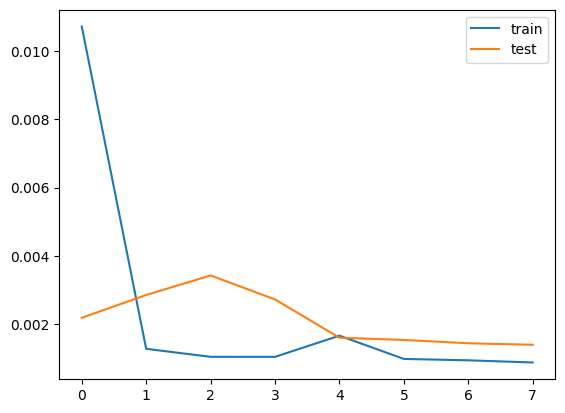

137/137 [==============================] - 1s 3ms/step
Test Score: 460.16 RMSE
Correlation 0.97544227854599 with p-value 0.0


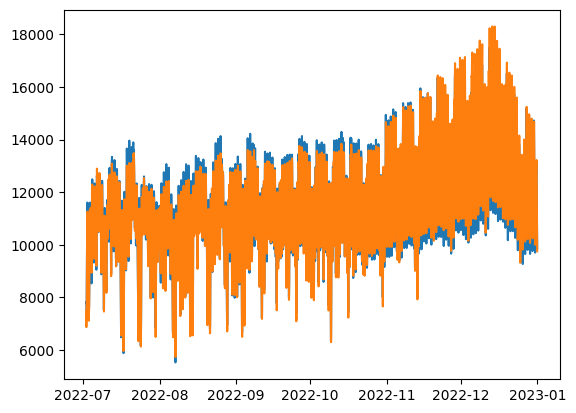

In [238]:
df_lstm, df_lstm_scaled, train, test, train_X, train_y, test_X, test_y, scaler, n_train_hours = create_model_input(forecast, df_subset)

# compile LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


yhat_inversed, test_y_inversed = run_lstm(model, test, n_train_hours, train_X, train_y, test_X, test_y, epochs=8, batch_size=8)

13140 4383
(13140, 1, 11) (13140,) (4383, 1, 11) (4383,)
Epoch 1/8
1643/1643 - 14s - loss: 0.0110 - val_loss: 0.0036 - 14s/epoch - 8ms/step
Epoch 2/8
1643/1643 - 10s - loss: 0.0015 - val_loss: 0.0037 - 10s/epoch - 6ms/step
Epoch 3/8
1643/1643 - 11s - loss: 0.0017 - val_loss: 0.0017 - 11s/epoch - 7ms/step
Epoch 4/8
1643/1643 - 11s - loss: 0.0012 - val_loss: 0.0013 - 11s/epoch - 7ms/step
Epoch 5/8
1643/1643 - 11s - loss: 0.0013 - val_loss: 0.0010 - 11s/epoch - 7ms/step
Epoch 6/8
1643/1643 - 11s - loss: 0.0013 - val_loss: 9.6969e-04 - 11s/epoch - 7ms/step
Epoch 7/8
1643/1643 - 10s - loss: 0.0012 - val_loss: 0.0010 - 10s/epoch - 6ms/step
Epoch 8/8
1643/1643 - 11s - loss: 0.0011 - val_loss: 0.0010 - 11s/epoch - 7ms/step


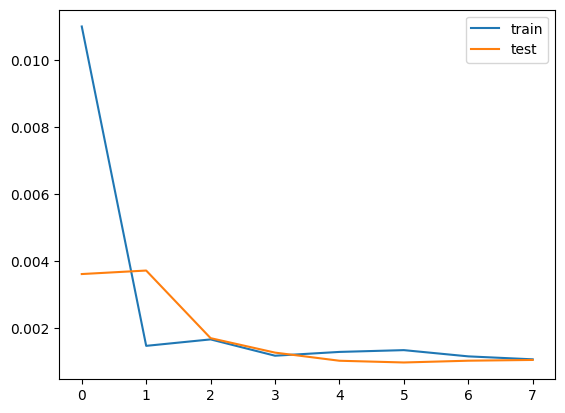

137/137 [==============================] - 1s 3ms/step
Test Score: 398.35 RMSE
Correlation 0.9791053579159092 with p-value 0.0


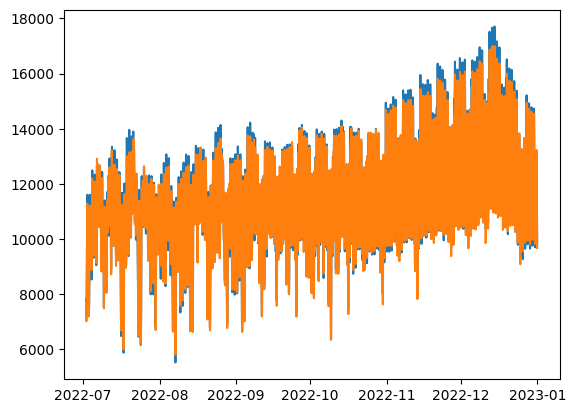

In [247]:
df_lstm, df_lstm_scaled, train, test, train_X, train_y, test_X, test_y, scaler, n_train_hours = create_model_input(forecast, df_subset)

# compile LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


yhat_inversed, test_y_inversed = run_lstm(model, test, n_train_hours, train_X, train_y, test_X, test_y, epochs=8, batch_size=8)

# Setup 2: LSTM from Tan et al (2020)

Model with 6 layers:
1. Input layer
2. LSTM: 50 nodes with sigmoid activation
3. Dropout 0.2
4. LSTM: 100 nodes with tanh activation
5. Dropout 0.3
6. Dense: linear activation function $f(x)=x$

They have their own loss function $L(y, \hat{y})$.
Using RMSprop optimizer.

13140 4383
(13140, 1, 11) (13140,) (4383, 1, 11) (4383,)
Epoch 1/8
1643/1643 - 13s - loss: 0.0102 - val_loss: 0.0226 - 13s/epoch - 8ms/step
Epoch 2/8
1643/1643 - 9s - loss: 0.0062 - val_loss: 0.0166 - 9s/epoch - 5ms/step
Epoch 3/8
1643/1643 - 8s - loss: 0.0043 - val_loss: 0.0119 - 8s/epoch - 5ms/step
Epoch 4/8
1643/1643 - 9s - loss: 0.0026 - val_loss: 0.0097 - 9s/epoch - 6ms/step
Epoch 5/8
1643/1643 - 9s - loss: 0.0019 - val_loss: 0.0091 - 9s/epoch - 5ms/step
Epoch 6/8
1643/1643 - 8s - loss: 0.0017 - val_loss: 0.0081 - 8s/epoch - 5ms/step
Epoch 7/8
1643/1643 - 9s - loss: 0.0016 - val_loss: 0.0072 - 9s/epoch - 6ms/step
Epoch 8/8
1643/1643 - 8s - loss: 0.0015 - val_loss: 0.0064 - 8s/epoch - 5ms/step


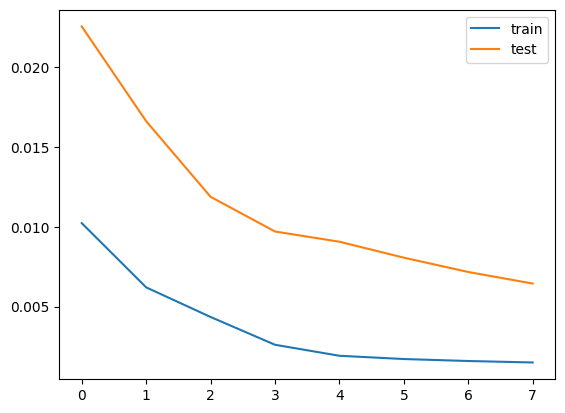

137/137 [==============================] - 1s 4ms/step
Test Score: 989.15 RMSE
Correlation 0.970465487986538 with p-value 0.0


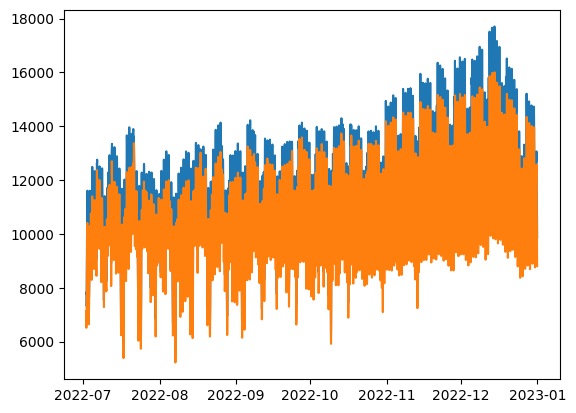

In [249]:
df_lstm, df_lstm_scaled, train, test, train_X, train_y, test_X, test_y, scaler, n_train_hours = create_model_input(forecast, df_subset)

# LSTM
model = Sequential()
model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
model.add(LSTM(50, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
# model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
model.add(LSTM(100, activation='tanh', name='LSTM_Layer_2'))
# model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
model.add(Dense(1, activation='linear', name='Dense_Layer'))
model.compile(optimizer='rmsprop', loss='mse')

yhat_inversed, test_y_inversed = run_lstm(model, test, n_train_hours, train_X, train_y, test_X, test_y, epochs=8, batch_size=8)

13140 4383
(13140, 1, 11) (13140,) (4383, 1, 11) (4383,)
Epoch 1/8
1643/1643 - 13s - loss: 0.0160 - val_loss: 0.0275 - 13s/epoch - 8ms/step
Epoch 2/8
1643/1643 - 9s - loss: 0.0108 - val_loss: 0.0223 - 9s/epoch - 5ms/step
Epoch 3/8
1643/1643 - 10s - loss: 0.0092 - val_loss: 0.0225 - 10s/epoch - 6ms/step
Epoch 4/8
1643/1643 - 10s - loss: 0.0082 - val_loss: 0.0190 - 10s/epoch - 6ms/step
Epoch 5/8
1643/1643 - 8s - loss: 0.0075 - val_loss: 0.0196 - 8s/epoch - 5ms/step
Epoch 6/8
1643/1643 - 9s - loss: 0.0070 - val_loss: 0.0202 - 9s/epoch - 5ms/step
Epoch 7/8
1643/1643 - 9s - loss: 0.0063 - val_loss: 0.0175 - 9s/epoch - 6ms/step
Epoch 8/8
1643/1643 - 8s - loss: 0.0059 - val_loss: 0.0159 - 8s/epoch - 5ms/step


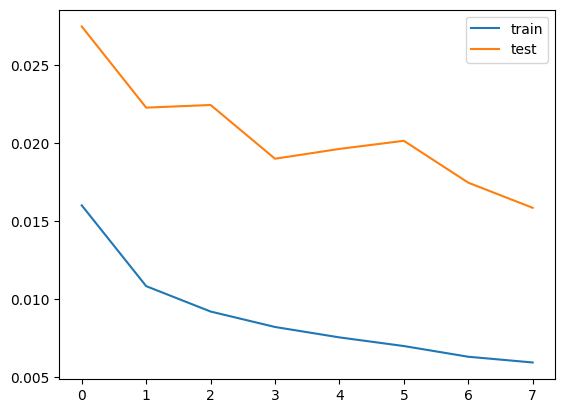

137/137 [==============================] - 1s 2ms/step
Test Score: 1551.24 RMSE
Correlation 0.7718285295096635 with p-value 0.0


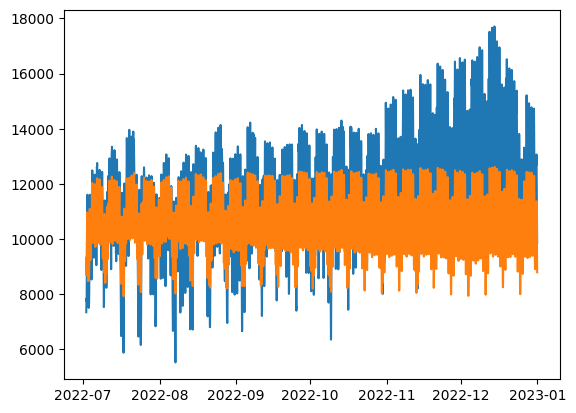

In [248]:
df_lstm, df_lstm_scaled, train, test, train_X, train_y, test_X, test_y, scaler, n_train_hours = create_model_input(forecast, df_subset)

# LSTM
model = Sequential()
model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
model.add(LSTM(50, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
model.add(LSTM(100, activation='tanh', name='LSTM_Layer_2'))
model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
model.add(Dense(1, activation='linear', name='Dense_Layer'))
model.compile(optimizer='rmsprop', loss='mse')

yhat_inversed, test_y_inversed = run_lstm(model, test, n_train_hours, train_X, train_y, test_X, test_y, epochs=8, batch_size=8)